**Chapter 10 – Introduction to Artificial Neural Networks with Keras**

_This notebook contains all the sample code and solutions to the exercises in chapter 10._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

Trial 10 Complete [00h 06m 13s]
val_accuracy: 0.9706190625826517

Best val_accuracy So Far: 0.9776666760444641
Total elapsed time: 01h 00m 55s
Best hyperparameters: {'num_layers': 2, 'units_0': 480, 'units_1': 512, 'learning_rate': 0.00010895548388121933}
Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8339 - loss: 0.6345 - val_accuracy: 0.9475 - val_loss: 0.1854
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9556 - loss: 0.1501 - val_accuracy: 0.9626 - val_loss: 0.1291
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9709 - loss: 0.1005 - val_accuracy: 0.9685 - val_loss: 0.1087
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.9795 - loss: 0.0697 - val_accuracy: 0.9716 - val_loss: 0.0991
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9842 - loss: 0.0545 - val_accuracy: 0.9742 - val_loss: 0.0872
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.9888 - loss: 0

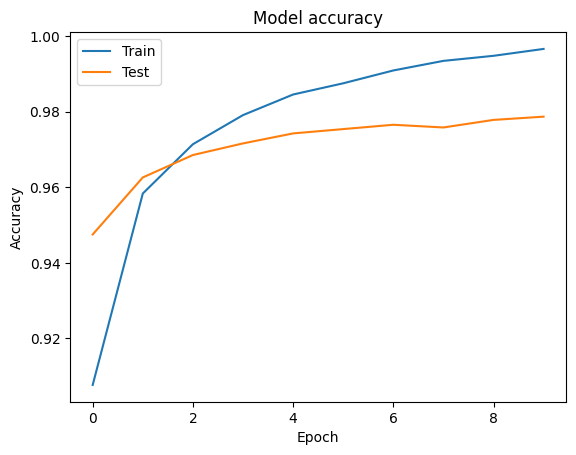

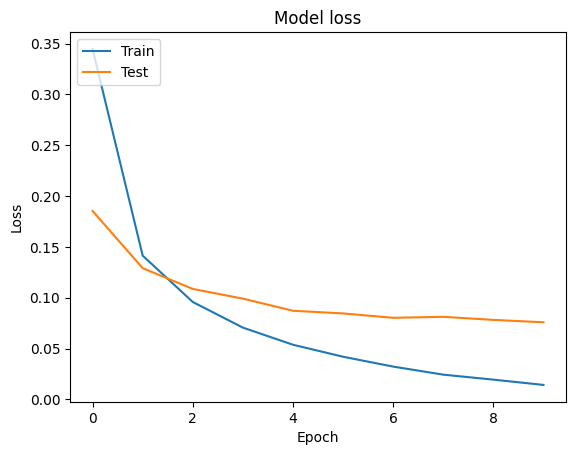

Best number of layers: 2
Best units in each layer: [480, 512]
Best learning rate: 0.00010895548388121933


In [5]:
!pip install keras-tuner -q  # Install keras-tuner if not already installed
import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import kerastuner as kt
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target

# Preprocess the data
X = X / 255.0  # Normalize pixel values to [0, 1]
y = to_categorical(y.astype(int))  # One-hot encode labels

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model-building function
def build_model(hp):
    model = Sequential()

    # Define the number of hidden layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=3, default=2)

    # Add hidden layers with variable number of units
    for i in range(num_layers):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32),
                               activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))  # 10 output classes for MNIST

    # Hyperparameter for learning rate
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Maximum number of trials to search
    executions_per_trial=3,
    directory='kt_dir',
    project_name='mnist_tuning'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Get the best hyperparameters from the tuner
best_hp = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:", best_hp.values)

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hp)

# Fetch batch_size from the best hyperparameters using dictionary indexing
batch_size = best_hp['batch_size'] if 'batch_size' in best_hp else 32

# Train the model using the best hyperparameters
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=batch_size)

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Summary of best hyperparameters
print(f"Best number of layers: {best_hp['num_layers']}")
print(f"Best units in each layer: {[best_hp[f'units_{i}'] for i in range(best_hp['num_layers'])]}")
print(f"Best learning rate: {best_hp['learning_rate']}")


In [ ]:
!pip install keras-tuner -q